In [1]:
from theFuncs import *

# DATA

In [2]:
# load_DTB3_SPY().to_csv('./data/spy_dtb3.csv')

In [3]:
sp100 = os.listdir(os.getcwd()+'/data/stock_dfs')
sp100_tickers = []
for csvfile in sp100:
    sp100_tickers.append(csvfile[:-4])

# sp100_tickers

In [4]:
ticker_data = get_ticker_data_multisource(
    sp100_tickers, 
    start="2019-01-02", 
    end="2021-11-01"
)
#start=2019-01-02
#end=2021-11-01

In [5]:
# nyse_tickers_cap = pd.read_csv("data/tickers_nyse.csv", index_col=0).MarketCap.dropna().apply(
#     lambda x: float(x[1: -1]) * 1e6 if x[-1] == "M" else float(x[1: -1]) * 1e6
# ).sort_values(ascending=False)[:200]

# nyse_tickers = nyse_tickers_cap.index

In [6]:
# nyse_ticker_weights = nyse_tickers_cap / nyse_tickers_cap.sum()
# nyse_ticker_weights.head()

In [7]:
# ticker_data = get_ticker_data_multisource(nyse_tickers)

In [8]:
tickers = sp100_tickers

model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[tickers[0]], 
        window = 66
    ).fit(params_only=True)
df = model.params
df.columns = ["alpha", "Beta"]
df['ticker'] = tickers[0]
df.set_index('ticker', inplace=True, append=True)
df = df.reorder_levels(['ticker', 'date']).sort_index()


for ticker in tickers[1:]:
    try:
        model = RollingOLS.from_formula(
            "(ret - DTB3) ~ (spy_ret - DTB3)", 
            data = ticker_data.loc[ticker], 
            window = 66
        ).fit(params_only=True)

        temp = model.params
        temp.columns = ["alpha", "Beta"]
        temp['ticker'] = ticker
        temp.set_index('ticker', inplace=True, append=True)
        temp = temp.reorder_levels(['ticker', 'date']).sort_index()
        df = pd.concat(
            [ 
                df, 
                temp
            ]
        )
    except:
        continue

ticker_data = ticker_data.join(df)

ticker_data.head()

high        low       open      close       volume  \
ticker date                                                                  
AAPL   2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0   
       2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0   
       2019-01-07  37.207500  36.474998  37.174999  36.982498  219111200.0   
       2019-01-08  37.955002  37.130001  37.389999  37.687500  164101200.0   
       2019-01-09  38.632500  37.407501  37.822498  38.327499  180396400.0   

                        ret   spy_close    DTB3   spy_ret  alpha  Beta  
ticker date                                                             
AAPL   2019-01-03 -0.099607  232.998627  0.0236 -0.023863    NaN   NaN  
       2019-01-04  0.042689  240.803085  0.0237  0.033496    NaN   NaN  
       2019-01-07 -0.002226  242.701736  0.0241  0.007885    NaN   NaN  
       2019-01-08  0.019063  244.981995  0.0241  0.009395    NaN   NaN  
       2019-01-09  0.016982  246.126907  0.0240  0.004673    NaN   NaN

In [9]:
market_caps = pd.DataFrame(
    ticker_data.close * ticker_data.volume,
    columns=["MarketCap"]
)
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  8.689088e+09
       2019-01-07  8.103280e+09
       2019-01-08  6.184564e+09
       2019-01-09  6.914143e+09

In [10]:
market_caps = market_caps.ewm(66).mean()

In [11]:
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  1.082024e+10
       2019-01-07  9.900934e+09
       2019-01-08  8.950780e+09
       2019-01-09  8.531111e+09

In [12]:
ticker_data_wide = ticker_data.reset_index(level=['ticker', 'date'])
ticker_data_wide = ticker_data_wide[['ticker', 'date', 'ret']].pivot(
    index='date', 
    columns='ticker', 
    values='ret'
)
ticker_data_wide.head()

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.099607,-0.032949,-0.047194,-0.034142,-0.039498,-0.021959,-0.015216,0.005997,-0.025242,-0.088951,...,-0.027270,-0.037016,-0.028392,-0.014024,-0.036037,0.003570,-0.010435,-0.007882,-0.005142,-0.015354
2019-01-04,0.042689,0.032217,0.028541,0.038884,0.048632,0.036903,0.034184,0.003995,0.050064,0.009828,...,0.011695,0.038514,0.034833,0.024726,0.043081,0.002490,0.033269,0.029633,0.006246,0.036870
2019-01-07,-0.002226,0.014595,0.014976,0.003473,0.013573,0.005724,0.013457,0.006190,0.034353,0.020366,...,0.001920,0.006241,-0.003376,-0.004698,0.018032,0.006388,0.005750,-0.006465,0.011772,0.005200
2019-01-08,0.019063,0.004648,-0.012006,0.025290,0.014918,0.003959,0.012824,0.011300,0.016612,-0.008026,...,0.013371,0.087270,0.000103,0.006436,0.005439,0.029267,0.020009,-0.002099,0.006981,0.007271
2019-01-09,0.016982,-0.032823,0.016691,0.005030,0.011819,0.014543,-0.001196,-0.008753,0.001714,0.043250,...,0.001439,-0.002587,0.005132,0.010659,0.011769,-0.022782,0.012050,0.005469,-0.003256,0.005275


In [13]:
rolling_correlations = ticker_data_wide.rolling(66).corr().fillna(0)
rolling_correlations.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2019-01-03 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2019-01-03 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [14]:
filter_correlations = rolling_correlations.groupby(["date"]).sum().sum(axis=1)
filter_correlations_dates = filter_correlations[filter_correlations > 0].index
rolling_correlations = rolling_correlations.loc[filter_correlations_dates]

In [15]:
rolling_covariances = ticker_data_wide.rolling(66).cov().fillna(0)
rolling_covariances.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2019-01-03 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2019-01-03 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [16]:
filter_covariances = rolling_covariances.groupby(["date"]).sum().sum(axis=1)
filter_covariances_dates = filter_covariances[filter_covariances > 0].index
rolling_covariances = rolling_covariances.loc[filter_covariances_dates]

In [17]:
rolling_covariances.loc[('2019-06-24', 'AAPL'), 'AAPL']

date        ticker
2019-06-24  AAPL      0.000275
Name: AAPL, dtype: float64

In [18]:
# ticker_data.to_csv("data/test_run/ticker_data.csv")
# ticker_data_wide.to_csv("data/test_run/ticker_data_wide.csv")
# rolling_correlations.to_csv("data/test_run/rolling_correlations.csv")
# rolling_covariances.to_csv("data/test_run/rolling_covariances.csv")
# market_caps.to_csv("data/test_run/market_caps.csv")

In [44]:
ticker_data = pd.read_csv("data/test_run/ticker_data.csv", index_col=[0, 1], parse_dates=True)
ticker_data_wide = pd.read_csv("data/test_run/ticker_data_wide.csv", index_col=0, parse_dates=True)
rolling_correlations = pd.read_csv("data/test_run/rolling_correlations.csv", index_col=[0, 1], parse_dates=True)
rolling_covariances = pd.read_csv("data/test_run/rolling_covariances.csv", index_col=[0, 1], parse_dates=True)
market_caps = pd.read_csv("data/test_run/market_caps.csv", index_col=[0, 1], parse_dates=True)

# CLUSTERING

In [115]:
date = get_closest_trading_day("2007-07-07", rolling_correlations)
K = 10

In [116]:
x, y, z = clustering_model(rolling_correlations, date, K, GRB.MAXIMIZE)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8557 rows, 8556 columns and 25484 nonzeros
Model fingerprint: 0x1748ff6c
Variable types: 0 continuous, 8556 integer (8556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 20.3549643
Presolve time: 0.04s
Presolved: 8557 rows, 8556 columns, 25484 nonzeros
Variable types: 0 continuous, 8556 integer (8556 binary)

Root relaxation: objective 5.165989e+01, 695 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   51.65989    0  190   20.35496   51.65989   154%     -    0s
H    0     0                      51.6435731   51.65989  0.03%     -    0s

Cutting

# INDEX BY CLUSTER WEIGHTS

In [117]:
z_market_cap = market_caps.loc[
    market_caps.index.get_level_values(1) == date
].join(z)
z_market_cap.reset_index(drop=True, level=1, inplace=True)

In [118]:
center_weights = z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].groupby("center").MarketCap.sum() / z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].MarketCap.sum()

In [119]:
portfolio_returns = get_portfolio_returns(
    center_weights, date, ticker_data_wide
)
spy_returns = get_spy_returns(date)

portfolio_returns, spy_returns

(1.065192546146051, 1.0289745236945667)

In [120]:
portfolio_returns - spy_returns

0.03621802245148431

In [121]:
get_portfolio_beta(center_weights, date, ticker_data)

1.0046971420895732

In [122]:
# master_func("2020-03-23", K, rolling_correlations, market_caps, ticker_data, ticker_data_wide, rolling_covariances, 0.5, 1.5, 1e-3)

# INDEX BY MIN VAR

In [123]:
mean_var_step, obj = mean_variance_model(
    market_caps, 
    ticker_data, 
    date, 
    rolling_covariances, 
    center_weights,
    0.5, 
    1.5, 
    1e-3
)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 84 rows, 90 columns and 437 nonzeros
Model fingerprint: 0xb0699073
Model has 4005 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-05, 2e+00]
  Objective range  [1e-05, 2e-04]
  QObjective range [2e-08, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 81 rows and 80 columns
Presolve time: 0.00s
Presolved: 3 rows, 11 columns, 31 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 6.600e+01
 Factor NZ  : 7.800e+01
 Factor Ops : 6.500e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.42890080e+05 -3.42936879e+05  7.25e+03 8.09e-03  3.63e+05     0s
   1   3.1

In [124]:
obj

0.0032685976277472134

In [125]:
mean_var_step_return = get_portfolio_returns(mean_var_step.weights, date, ticker_data_wide)
mean_var_step_return, spy_returns

(1.0672660862504322, 1.0289745236945667)

In [126]:
mean_var_step_return - spy_returns

0.03829156255586552

In [127]:
get_portfolio_beta(mean_var_step.weights, date, ticker_data)

0.9258824270589381

# Method Comparison

In [128]:
pd.concat(
    [
        mean_var_step[mean_var_step.weights > 0], 
        center_weights
    ], 
    axis=1
)

,weights,MarketCap
AXP,0.108392,0.066919
EMR,0.097749,0.037077
GOOG,0.271019,0.110402
HON,0.187254,0.057541
JNJ,0.151581,0.072425
LOW,0.009679,0.051862
NFLX,0.005223,0.070829
ORCL,0.150448,0.222283
SO,0.000002,0.160195
WFC,0.018653,0.150467


# Master Func

In [113]:
start_date = get_closest_trading_day("2000-01-01", rolling_correlations)
end_date = max(ticker_data.index.get_level_values("date"))

master_cluster_index = {}
master_cluster_performance = {}
master_mean_var_index = {}
master_mean_var_performance = {}

while start_date < end_date:
    master_func(
        start_date, 
        10, 
        rolling_correlations, 
        market_caps, 
        ticker_data, 
        ticker_data_wide, 
        rolling_covariances,
        0.5, 
        1.5, 
        1e-3, 
        master_cluster_index,
        master_cluster_performance,
        master_mean_var_index,
        master_mean_var_performance, 
        # GRB.MINIMIZE
        )
    print(start_date)

    start_date += relativedelta(months=3)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 8557 rows, 8556 columns and 25484 nonzeros
Model fingerprint: 0x1ef33024
Variable types: 0 continuous, 8556 integer (8556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 19.6765781
Presolve time: 0.04s
Presolved: 8557 rows, 8556 columns, 25484 nonzeros
Variable types: 0 continuous, 8556 integer (8556 binary)

Root relaxation: objective 4.778560e+01, 836 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   47.78560    0  156   19.67658   47.78560   143%     -    0s
H    0     0                      46.5346522   47.78560  2.69%     -    0s
H    0  

In [60]:
method1_index = pd.DataFrame.from_dict(master_cluster_index, orient="index")
method1_index

weight
2006-04-07 CAT    0.160078
           CL     0.022212
           CVX    0.045649
           GE     0.060574
           GOOGL  0.160740
...                    ...
2008-10-07 GOOG   0.114653
           HD     0.061785
           MA     0.037408
           MCD    0.092658
           MMM    0.131062

[110 rows x 1 columns]

<AxesSubplot:>

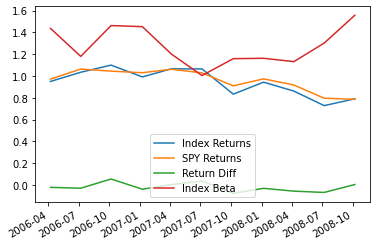

In [61]:
method1_performance = pd.DataFrame.from_dict(master_cluster_performance, orient="index")
method1_performance.plot()

In [62]:
method2_index = pd.DataFrame.from_dict(master_mean_var_index, orient="index")
method2_index

weight
2006-04-07 CAT    2.713559e-01
           CL     1.114109e-01
           CVX    6.377952e-02
           GE     1.320774e-06
           GOOGL  1.342238e-01
           KO     4.982467e-02
           LOW    2.637785e-06
           QCOM   1.727130e-01
           SO     1.872342e-07
           USB    1.966879e-01
2006-07-07 BIIB   5.142056e-02
           CVX    1.056913e-01
           GOOG   2.021858e-01
           GS     1.969472e-04
           JPM    1.188558e-01
           KO     2.018093e-01
           LIN    4.172930e-02
           RTX    1.206144e-01
           SO     2.388193e-04
           UPS    1.572577e-01
2008-01-07 BAC    1.349215e-01
           BIIB   1.256344e-02
           CVS    1.035525e-01
           CVX    1.136836e-01
           DUK    3.143103e-02
           GOOG   2.844305e-01
           LIN    5.084778e-02
           MET    1.038398e-01
           ORCL   1.184621e-01
           SPG    4.626781e-02
2008-04-07 BAC    4.414351e-01
           BRK-B  2.939768e-08
           DD     5.584687e-01
           GOOG   5.862367e-09
           KO     9.552103e-05
           MRK    5.121970e-09
           SO     3.511910e-08
           UNH    3.644857e-09
           VZ     1.902703e-08
           XOM    6.044980e-07
2008-07-07 CSCO   1.519205e-01
           CVX    9.638382e-02
           GD     8.595529e-02
           GOOGL  1.465799e-01
           MS     9.521079e-02
           NEE    9.563923e-02
           PEP    1.075676e-01
           TGT    1.451265e-01
           TMUS   1.514404e-02
           V      6.047226e-02
2008-10-07 ADBE   1.307184e-01
           AMT    3.792884e-02
           BAC    1.215244e-01
           BIIB   1.479483e-02
           CVX    1.590216e-01
           GOOG   1.372341e-01
           HD     1.278881e-01
           MA     1.006688e-01
           MCD    6.518264e-02
           MMM    1.050384e-01

<AxesSubplot:>

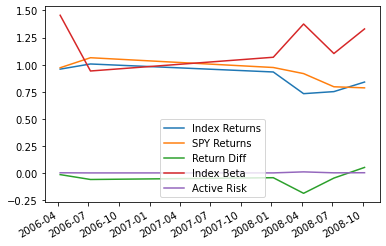

In [63]:
method2_performance = pd.DataFrame.from_dict(master_mean_var_performance, orient="index")
method2_performance.plot()

In [64]:
comp_index = method1_index.join(
    method2_index, 
    lsuffix=" method 1", 
    rsuffix=" method 2"
)
comp_index

weight method 1  weight method 2
2006-04-07 CAT           0.160078         0.271356
           CL            0.022212         0.111411
           CVX           0.045649         0.063780
           GE            0.060574         0.000001
           GOOGL         0.160740         0.134224
...                           ...              ...
2008-10-07 GOOG          0.114653         0.137234
           HD            0.061785         0.127888
           MA            0.037408         0.100669
           MCD           0.092658         0.065183
           MMM           0.131062         0.105038

[110 rows x 2 columns]

In [65]:
comp_performance = method1_performance.join(
    method2_performance, 
    lsuffix=" Method 1", 
    rsuffix=" Method 2"
).fillna(method="ffill")
comp_performance

,Index Returns Method 1,SPY Returns Method 1,Return Diff Method 1,Index Beta Method 1,Index Returns Method 2,SPY Returns Method 2,Return Diff Method 2,Index Beta Method 2,Active Risk
2006-04-07,0.950307,0.971725,-0.021418,1.437268,0.959021,0.971725,-0.012704,1.455200,0.004180
2006-07-07,1.034876,1.064060,-0.029184,1.180245,1.006459,1.064060,-0.057600,0.941836,0.002896
2006-10-06,1.100119,1.044824,0.055296,1.462867,1.006459,1.064060,-0.057600,0.941836,0.002896
2007-01-08,0.991954,1.030398,-0.038445,1.453110,1.006459,1.064060,-0.057600,0.941836,0.002896
2007-04-05,1.066089,1.062467,0.003621,1.201795,1.006459,1.064060,-0.057600,0.941836,0.002896
2007-07-06,1.065193,1.028975,0.036218,1.004697,1.006459,1.064060,-0.057600,0.941836,0.002896
2007-10-08,0.833954,0.909860,-0.075906,1.159259,1.006459,1.064060,-0.057600,0.941836,0.002896
2008-01-07,0.943735,0.974015,-0.030279,1.162725,0.932788,0.974015,-0.041227,1.068400,0.003093
2008-04-07,0.861682,0.917856,-0.056175,1.132315,0.733010,0.917856,-0.184846,1.374676,0.012553
2008-07-07,0.728583,0.796524,-0.067942,1.302089,0.751919,0.796524,-0.044605,1.102687,0.003756


In [66]:
comp_performance[
    ["Return Diff Method 1", "Return Diff Method 2"]
].add(1).cumprod().fillna(method="ffill")

,Return Diff Method 1,Return Diff Method 2
2006-04-07,0.978582,0.987296
2006-07-07,0.950023,0.930427
2006-10-06,1.002556,0.876834
2007-01-08,0.964013,0.826328
2007-04-05,0.967504,0.778732
2007-07-06,1.002545,0.733876
2007-10-08,0.926446,0.691605
2008-01-07,0.898393,0.663092
2008-04-07,0.847927,0.540522
2008-07-07,0.790317,0.516412


<AxesSubplot:>

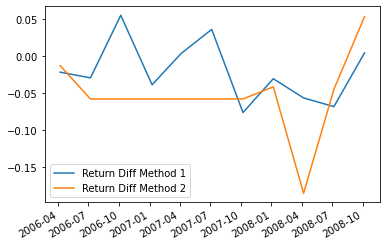

In [67]:
comp_performance.plot(y=["Return Diff Method 1", "Return Diff Method 2"])

<AxesSubplot:>

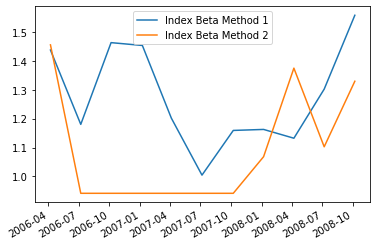

In [68]:
comp_performance.plot(y=["Index Beta Method 1", "Index Beta Method 2"])